In [1]:
import numpy as np

from keras.datasets import cifar10
from keras.models import Sequential
from keras.optimizers import rmsprop
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Activation
from keras.utils import to_categorical
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, TensorBoard
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator

import cv2

from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, GaussianBlur, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, ToGray, RandomCrop, HorizontalFlip, OneOf, Compose
)

In [3]:
def show_random_images(ds, labels, h=5, w=5):
    idxs = np.random.randint(0, ds.shape[0] - 1, size=w * h).tolist()
    
    plt.figure(figsize=(1.5 * w, 1.5 * h))
    for i, idx in enumerate(idxs):
        plt.subplot(h, w, i + 1)
        image = ds[idx].reshape(image_height, image_width, n_channels)
        plt.imshow(image)
        plt.title(LABELS[labels[idx][0]])
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

In [4]:
def show_random_images_by_class(x, labels, l_text, n_classes, img_per_class=10):
    inch_per_pic = 1
    fig, plots = plt.subplots(n_classes, img_per_class)
    fig.set_size_inches(inch_per_pic * img_per_class, inch_per_pic * n_classes)

    for cls in range(n_classes):
        imgs = x[np.argwhere(labels == cls)[:, 0].flatten()]
        imgs = imgs[np.random.choice(imgs.shape[0], size=img_per_class, replace=False)]
        plots[cls, 0].set_ylabel(l_text[cls], va='center', ha='right',rotation=0, size=15)
        for i in range(img_per_class):
            plots[cls, i].imshow(imgs[i])
            plots[cls, i].set_xticks([])
            plots[cls, i].set_yticks([])
    fig.tight_layout()

In [5]:
def show_images(ds, labels, h=5, w=5):
    n_img = min(h * w, ds.shape[0])
    
    plt.figure(figsize=(1.5 * w, 1.5 * h))
    for i in range(n_img):
        plt.subplot(h, w, i + 1)
        image = ds[i].reshape(image_height, image_width, n_channels)
        plt.imshow(image)
        plt.title(LABELS[np.argmax(labels[i])])
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

In [6]:
def predict_random_images(ds, model, h=5, w=5):
    idxs = np.random.randint(0, ds.shape[0] - 1, size=w * h).tolist()
    subset = ds[idxs]
    labels = model.predict_classes(subset, verbose=0)
    
    plt.figure(figsize=(1.5 * w, 1.5 * h))    
    for i, label in enumerate(labels):
        plt.subplot(h, w, i + 1)
        image = subset[i].reshape(image_height, image_width, 3)
#         image = image.astype(np.uint8)
        plt.imshow(image)
        plt.title(LABELS[label])
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

In [7]:
def show_most_confident_predictions(ds, model, h=5, w=5, reverse=False):
    n_img = min(h * w, ds.shape[0])
    
    preds = model.predict(ds, verbose=0)
    if reverse:
        extreame_conf = np.argsort(np.max(preds, axis=1))[:n_img]
    else:
        extreame_conf = np.argsort(np.max(preds, axis=1))[-n_img::-1]
    x = ds[extreame_conf]
    preds = [preds[i] for i in extreame_conf]
    
    plt.figure(figsize=(1.5 * w, 1.5 * h))
    for i in range(n_img):
        plt.subplot(h, w, i + 1)
        image = x[i].reshape(image_height, image_width, n_channels)
        plt.imshow(image)
        title = '%s\n%0.2f%%' % (LABELS[np.argmax(preds[i])], 100 * np.max(preds[i]))
        plt.title(title)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

In [8]:
def plot_history(history, params=['loss', 'acc']):
    for param in params:
        plt.plot(history.history[param], label='train')
        if 'val_%s' % param in history.history.keys():
            plt.plot(history.history['val_%s' % param], label='test')
        plt.xlabel('epoch')
        plt.ylabel(param)
        plt.title(param.capitalize())
        plt.legend()
        plt.show()

In [9]:
image_height, image_width = 32, 32
n_channels = 3
batch_size = 32
LABELS = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
n_classes = len(LABELS)

In [10]:
(x_train, y_train), (x_val, y_val) = cifar10.load_data()

In [11]:
print(x_train.shape, y_train.shape) 
print(x_val.shape, y_val.shape) 

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


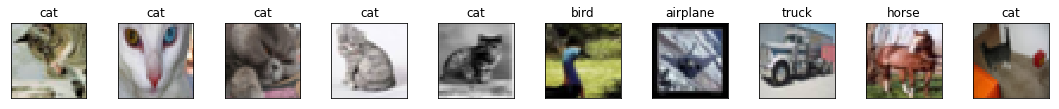

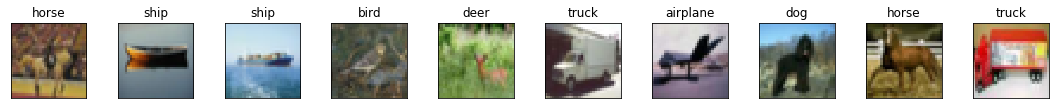

In [12]:
show_random_images(x_train, y_train, 1, 10)
show_random_images(x_val, y_val, 1, 10)

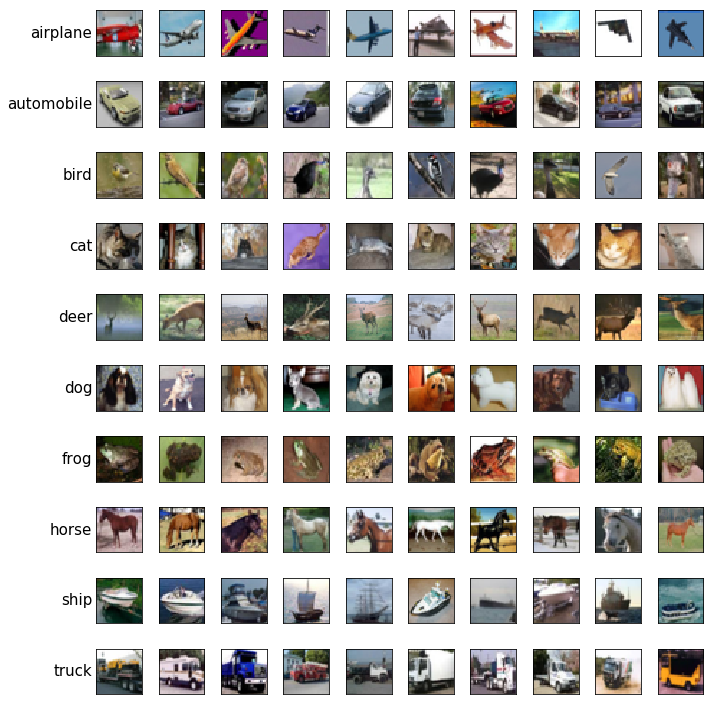

In [13]:
show_random_images_by_class(x_train, y_train, LABELS, 10)

In [13]:
y_train = to_categorical(y_train, n_classes)
y_val = to_categorical(y_val, n_classes)

In [14]:
x_train = x_train / 255.
x_val = x_val / 255.

In [15]:
def lr_scheduler(epoch):
    lr = 1e-3
    if epoch > 60:
        lr = 5e-4
    if epoch > 100:
        lr = 3e-4
    if epoch > 125:
        lr = 1e-4
    if epoch > 150:
        lr = 5e-5
    return lr

In [56]:
def build_model():
    model= Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same',
                     kernel_regularizer=regularizers.l2(1e-4),
                     data_format='channels_last', input_shape=(32, 32, n_channels)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=32, kernel_size=(3, 3), 
                     kernel_regularizer=regularizers.l2(1e-4),
                     padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), 
                     kernel_regularizer=regularizers.l2(1e-4),
                     padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(3, 3), 
                     kernel_regularizer=regularizers.l2(1e-4),
                     padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
        
    model.add(Conv2D(filters=128, kernel_size=(3, 3), 
                     kernel_regularizer=regularizers.l2(1e-4),
                     padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128, kernel_size=(3, 3), 
                     kernel_regularizer=regularizers.l2(1e-4),
                     padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Dense(n_classes, activation='softmax'))
    
    opt = rmsprop(lr=1e-3, decay=1e-3/300.)

    model.compile(optimizer=opt, loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [60]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_13 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_14 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
__________

In [61]:
def preproc(image):
    aug = Compose([
        ShiftScaleRotate(shift_limit=0.1, scale_limit=0.5, rotate_limit=40, p=1),
        HorizontalFlip(p=.7),
        HueSaturationValue(p=.3, hue_shift_limit=.05, sat_shift_limit=.05, val_shift_limit=.05)
    ], p=0.8)
    return np.clip(aug(image=image)['image'], 0., 1.)

In [62]:
datagen = ImageDataGenerator(preprocessing_function=preproc)
generator = datagen.flow(x_train, y_train, batch_size=batch_size)

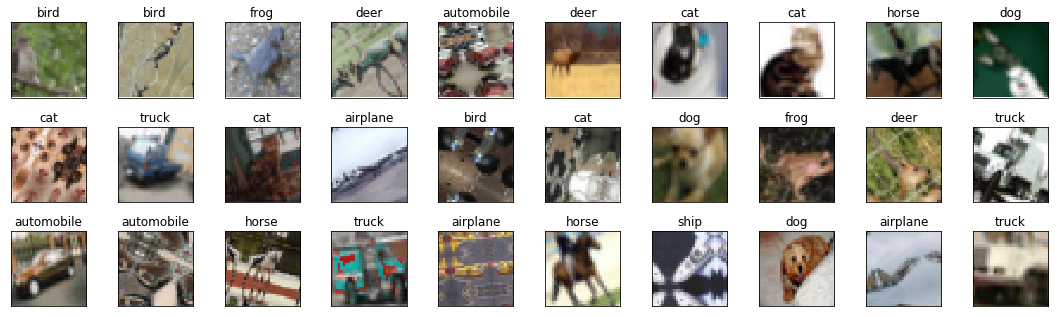

In [65]:
x_batch, y_batch = next(generator)
show_images(x_batch, y_batch, 3, 10)

In [66]:
l_sch = LearningRateScheduler(lr_scheduler)
check = ModelCheckpoint('models/model_epoch_{epoch:02d}_val_acc_{val_acc:.5f}.hdf5',
                         monitor='val_acc',
                         mode='max',
                         save_best_only=True)
tb = TensorBoard(log_dir="logs", write_graph=True, write_images=True)

In [67]:
history_aug = model.fit_generator(generator,
                                  epochs=300,
                                  steps_per_epoch=2 * len(generator),
                                  validation_data=(x_val, y_val),
                                  callbacks=[check, tb])

Epoch 1/300
3126/3126 [==============================] - 29s 9ms/step - loss: 1.7451 - acc: 0.3989 - val_loss: 1.2661 - val_acc: 0.5853
Epoch 2/300
3126/3126 [==============================] - 27s 9ms/step - loss: 1.3835 - acc: 0.5434 - val_loss: 1.0786 - val_acc: 0.6612
Epoch 3/300
3126/3126 [==============================] - 27s 9ms/step - loss: 1.2781 - acc: 0.5938 - val_loss: 1.0981 - val_acc: 0.6526
Epoch 4/300
3126/3126 [==============================] - 27s 9ms/step - loss: 1.2225 - acc: 0.6218 - val_loss: 0.9291 - val_acc: 0.7206
Epoch 5/300
3126/3126 [==============================] - 27s 9ms/step - loss: 1.1888 - acc: 0.6380 - val_loss: 0.8780 - val_acc: 0.7505
Epoch 6/300
3126/3126 [==============================] - 27s 9ms/step - loss: 1.1641 - acc: 0.6492 - val_loss: 0.7904 - val_acc: 0.7796
Epoch 7/300
3126/3126 [==============================] - 28s 9ms/step - loss: 1.1445 - acc: 0.6625 - val_loss: 0.9303 - val_acc: 0.7315
Epoch 8/300
3126/3126 [=========================

Epoch 61/300
3126/3126 [==============================] - 27s 9ms/step - loss: 0.8886 - acc: 0.7541 - val_loss: 0.5677 - val_acc: 0.8648
Epoch 62/300
3126/3126 [==============================] - 27s 9ms/step - loss: 0.8839 - acc: 0.7561 - val_loss: 0.5655 - val_acc: 0.8626
Epoch 63/300
3126/3126 [==============================] - 27s 9ms/step - loss: 0.8801 - acc: 0.7584 - val_loss: 0.5962 - val_acc: 0.8543
Epoch 64/300
3126/3126 [==============================] - 27s 9ms/step - loss: 0.8806 - acc: 0.7578 - val_loss: 0.5637 - val_acc: 0.8638
Epoch 65/300
3126/3126 [==============================] - 27s 9ms/step - loss: 0.8790 - acc: 0.7564 - val_loss: 0.5722 - val_acc: 0.8586
Epoch 66/300
3126/3126 [==============================] - 27s 9ms/step - loss: 0.8744 - acc: 0.7576 - val_loss: 0.5731 - val_acc: 0.8579
Epoch 67/300
3126/3126 [==============================] - 27s 9ms/step - loss: 0.8752 - acc: 0.7579 - val_loss: 0.5684 - val_acc: 0.8581
Epoch 68/300
3126/3126 [=================

3126/3126 [==============================] - 29s 9ms/step - loss: 0.7565 - acc: 0.7881 - val_loss: 0.4684 - val_acc: 0.8864
Epoch 180/300
3126/3126 [==============================] - 29s 9ms/step - loss: 0.7473 - acc: 0.7909 - val_loss: 0.4684 - val_acc: 0.8830
Epoch 181/300
3126/3126 [==============================] - 30s 10ms/step - loss: 0.7530 - acc: 0.7900 - val_loss: 0.4452 - val_acc: 0.8907
Epoch 182/300
3126/3126 [==============================] - 29s 9ms/step - loss: 0.7494 - acc: 0.7909 - val_loss: 0.4596 - val_acc: 0.8840
Epoch 183/300
3126/3126 [==============================] - 29s 9ms/step - loss: 0.7512 - acc: 0.7889 - val_loss: 0.4653 - val_acc: 0.8838
Epoch 184/300
3126/3126 [==============================] - 29s 9ms/step - loss: 0.7502 - acc: 0.7895 - val_loss: 0.4408 - val_acc: 0.8942
Epoch 185/300
3126/3126 [==============================] - 28s 9ms/step - loss: 0.7466 - acc: 0.7916 - val_loss: 0.4485 - val_acc: 0.8929
Epoch 186/300
3126/3126 [======================

3126/3126 [==============================] - 27s 9ms/step - loss: 0.6933 - acc: 0.8030 - val_loss: 0.4100 - val_acc: 0.8973
Epoch 298/300
3126/3126 [==============================] - 27s 8ms/step - loss: 0.6910 - acc: 0.8041 - val_loss: 0.4034 - val_acc: 0.8967
Epoch 299/300
3126/3126 [==============================] - 27s 9ms/step - loss: 0.6893 - acc: 0.8042 - val_loss: 0.4074 - val_acc: 0.8979
Epoch 300/300
3126/3126 [==============================] - 27s 9ms/step - loss: 0.6928 - acc: 0.8030 - val_loss: 0.4058 - val_acc: 0.8979


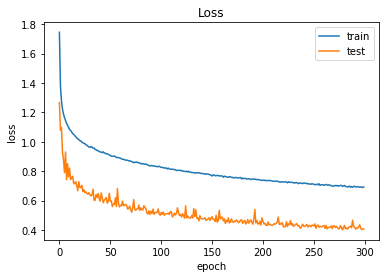

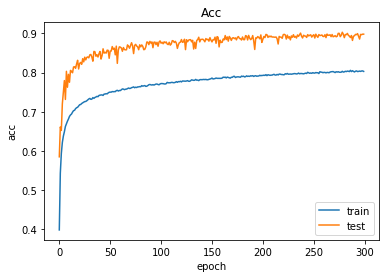

In [68]:
plot_history(history_aug)

In [69]:
acc = 100 * model.evaluate(x_val, y_val, verbose=0)[1]
print('Model acc: %0.2f%%' % acc)

Model acc: 89.79%


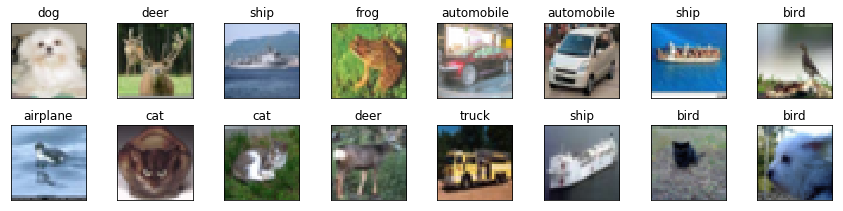

In [70]:
predict_random_images(x_val, model, 2, 8)

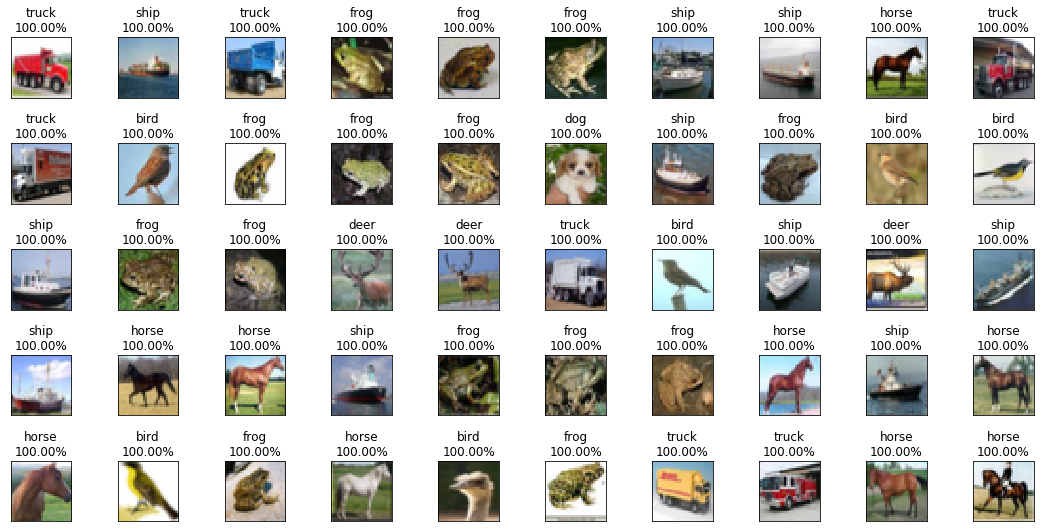

In [71]:
show_most_confident_predictions(x_val, model, h=5, w=10)

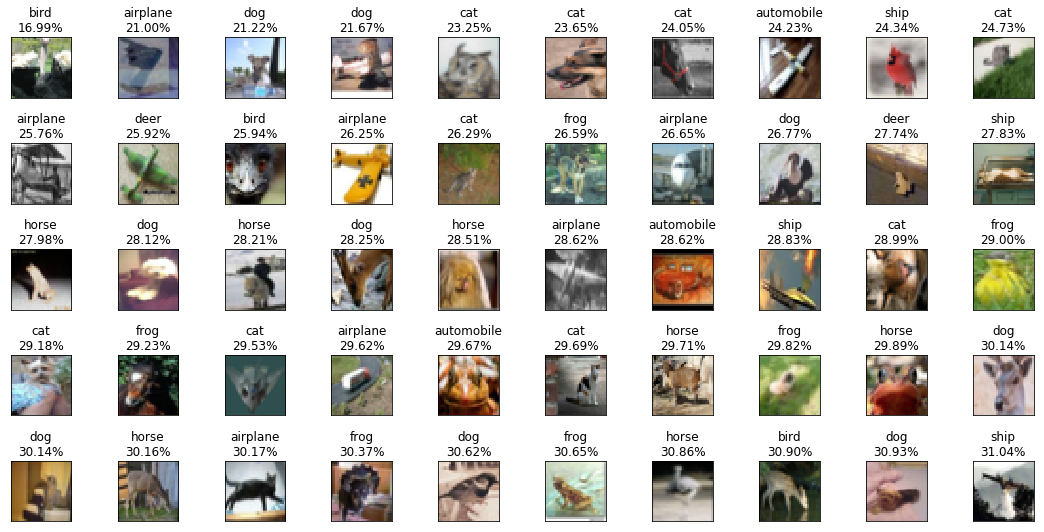

In [72]:
show_most_confident_predictions(x_val, model, h=5, w=10, reverse=True)

In [57]:
# model.save('model_acc_9098.hdf5')